Connect the Cosmic Watch to the red pitaya. To check things are working try to trigger some muons on the red pitaya. 
First, We will load the redpitaya. We will load an overlay. An Overlay is a fancy word for FPGA firmware. What this is actully doing is loading precompiled code onto your FPGA. The code in this case runs a simple oscilliscope and generator. It looks exactly like the tool that you used in the past.

In [1]:
from redpitaya.overlay.mercury import mercury as overlay
fpga = overlay()

Now what we want to do is load channel 1 of the oscillcope. This is labelled as channel 0.

In [2]:
osc0 = fpga.osc(0, 1.0)#note the 1.0 is for the voltage range either 1.0 or 20.0 volts
#osc1 = fpga.osc(1, 1.0) This is for channel 2 of the oscillscope for reference. 
print(osc0)

Now what we want to do is just plot a random readout of the scope. Lets do that quickly. We need to load matplotlib, and then we just need to call the scope data function. Here are the lines with some explanation.

triggered
[-0.02502518 -0.0249031  -0.02429273 ..., -0.02441481 -0.02502518
 -0.02429273]


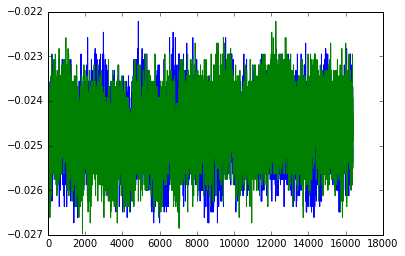

In [8]:
import matplotlib.pyplot as plt 
size = osc0.buffer_size  #This is the size of the memory array that the red pitaya writes the puleses to. 
osc0.reset() # this resets the readout of the red pitaya
osc0.start() # this starts the readout of the red pitaya
buff = osc0.data(size) #This loads the data from the data array the size is the full buffer size
print(buff)   #Now lets look at it
plt.plot(buff)
plt.show()

Now lets just setup the trigger code for this. This is really just you scope setup. Except now you have pre and post, which allow you to move the position of the trigger. Namely pre is the number of samples before and post is the number of samples after the scope. The sampling frequency on the red pitaya is 125 MHz so each sample point is 8ns=1/125MHz

In [9]:
#we will save 1/4 of the buffer before the pulse and 3/4 of the buffer after
osc0.trigger_pre  = size//4*1 # Note that // means divide and floor(round down) output 
osc0.trigger_post = size//4*3
#osc0.sync_src = fpga.sync_src["osc0"] #Points to a software trigger (ie from the generator)
osc0.trig_src = fpga.trig_src["osc0"]  #Points the trigger to go from the same channel
osc0.level = 0.05   # This is the trigger threshold in Volts
osc0.edge  = 'pos'  # options : 'pos' or 'neg' (slope to trigger on)


Now lets run and wait for a trigger to pass. We add that with a while loop. Note that we set the trigger position to be size//4 = (16384/4)=4096.

triggered
[-0.0253914  -0.02563555 -0.02368236 ..., -0.02417066 -0.02429273
 -0.02429273]


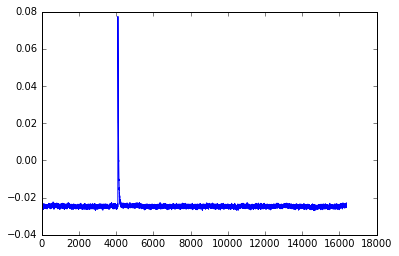

NameError: name 'plot' is not defined

In [11]:
osc0.reset()
osc0.start()
while (osc0.status_run()): pass
print('triggered')
buff = osc0.data(size)
print(buff)
plt.plot(buff)
plt.show()
#Now lets zoom in around the triggered pulse
plt.axvline(size//4-4000,c='r') #This is the trigger line
plt.plot(buff[4000:5000])
plt.show()

Now the code is to setup a real-time monitoring setup. You can just take all of this code and run it. 

In [ ]:
#Setup realtime monitoring system
import numpy as np
from bokeh.io import push_notebook, show, output_notebook    #Commands for updating plots
from bokeh.models import HoverTool, Range1d                  #Commands for hoeveing over the plot
from bokeh.plotting import figure                            #Plotting tool
from bokeh.resources import INLINE                           #Other resources
output_notebook(resources=INLINE)                            #Start the image

x = np.arange(size)                                          #Make an array the size of the trigger output
colors = ('red', 'blue')                                     #Pick two colors
hover = HoverTool(mode = 'vline', tooltips=[("T", "@x"), ("V", "@y")]) #Nice hover tool
tools = "pan,wheel_zoom,box_zoom,reset,crosshair"                      #fun viwer tools
p = figure(plot_height=500, plot_width=900, title="oscilloscope", toolbar_location="above", tools=(tools, hover))#figure
p.xaxis.axis_label='time [s]'                                # Put label on x-axis
p.yaxis.axis_label='voltage [V]'                             # Put label on y-axis
p.y_range=Range1d(-1.2, 1.2)                                 # Put a range on the y-axis
r = p.line(x, buff, line_width=1, line_alpha=0.7, color=colors[0])  # Plot the initial setup
target = show(p, notebook_handle=True)                       # Plot this guy

Now lets run this continuously and update the realtime plot too. FYI to stop the line from running below just press the stop button the notebook. 

In [ ]:
while True:
    osc0.reset()                            #reset
    osc0.start()                            #Start it up
    while osc0.status_run(): pass           #Keep running until the trigger passes
    buff = osc0.data(size)                  #Get the data and plot it
    r.data_source.data['y'] = buff          #Plot the pulse
    push_notebook(handle=target)            #Push this guy to the real time plot

Now what we can do is make a real time histogram of the max energy of each pulse. We will use the tools above with a new real time window. 

In [ ]:
#Lets use this real-time plotting setup
nbins=100
x = np.arange(nbins)/100.                                          #X-axis
y = np.zeros(nbins)                                           #Y-axis
p = figure(plot_height=500, plot_width=900, title="Realtime Histo", toolbar_location="above", tools=(tools, hover))#figure
p.yaxis.axis_label='N'                                # Put label on x-axis
p.xaxis.axis_label='voltage [V]'                      # Put label on y-axis
p.y_range=Range1d(0,20)                          # Put a range on the y-axis
r2 = p.line(x, buff, line_width=1, line_alpha=0.7, color=colors[0])  # Plot the initial setup
target2 = show(p, notebook_handle=True)                       # Plot this guy

We need to make a function to process the pulse. What this function is doing is finding max pulse and saving it to a histogram by hand. Be sure to look closely since this will run pretty slowly. 

In [ ]:
#Lets make a function that fills our array
def fillBins(iData,iY):                  
    maxval=np.max(iData)*100    #Take the max value and multipliy it by 100 (ie so bin1 corresponds to 0.01V and 0.02V for bin2...)
    if maxval < 0: # ignore negatives
        maxval=0
    if maxval > 100: #saturate at 1V
        maxval=100          
    iY[int(maxval)] = iY[int(maxval)] +1 #Fill the histogram
    
y = np.zeros(nbins)                                           #Y-axis
while True:
    osc0.reset()                            #reset
    osc0.start()                            #Start it up
    while osc0.status_run(): pass           #Keep running until the trigger passes
    buff = osc0.data(size)                  #Get the data and plot it
    fillBins(buff,y)
    #r.data_source.data['y'] = buff          #Plot the pulse (skipping this for now)
    #push_notebook(handle=target)            #Push this guy
    r2.data_source.data['y'] = y            #Plot the pulse
    push_notebook(handle=target2)           #Push this to the realtime setup

Now that you have walked through how to do this. There are a few steps that you can do to play with this. Here is what you should do:

1. Modify the code above to save the max pulse to a file. using python write file commands. 
2. To get this file you need to ssh onto the red pitaya. To do this: 
       a. scp root@rp-XXXXX.local:/home/jupyter/RedPitaya/$FILENAME . 
       (where XXXX is your local red pitaya address, password is root, and $FILENAME is your filename)
3. Once you have it working run this for a while and plot the energy distribution of cosmic muons going through the sample.What is the distribution? What does it look like? 
4. Now, lets make a muon telescope. Hook up two cosmic watches together and setup a synchronized trigger by requiring two pulses to appear nearby? What sort of conditions are needed to tie them together?
Now we are ready to do a lot of things, perhaps the muonlifetime?
5. Think about other things you might be able to read with this setup? Nuclear radiation?
